Moran model:

The Moran model describes the frequency of different
genes in a population of fixed size
$N$. Here we will consider a haploid population with a genotype
composed of a single locus, which can be occupied by one of two alleles,
$a$
and
$A$. We will assume
that both alleles are present in the population. Denote the number of individuals with allele
$a$ by $j$, and the number of individuals with allele $A$ by $N-j$. The Moran model assumes that birth and death occur simultaneously, as a single event. First an individual is chosen to reproduce with mutation. A second individual is then chosen to die. The probability of selection of individuals $a$ and $A$ is $s_{a}$ and $s_{A}$ respectively which are determined with some fittnesses $f$ and $g$. The birth-death event constitutes a single step in the Moran process.

Denote the number of individuals with allele
$a$ at time
$t$ by $X_t$. The transition probabilities for this Moran process are
given by

\begin{equation}
\begin{split}
&P(X_{t+1}=j+1\,|\, X_t=j)= (s_{a}(1-\mu_{a}) + s_{A}\mu_{A})\,\frac{N-j}{N}\\
&P(X_{t+1}=j-1\,|\,X_t=j)= (s_{a}\mu_{a} + s_{A}(1-\mu_{A}))\,\frac{j}{N}
\end{split}
\end{equation}

where $$ s_a = \frac{f\,j}{f\,j+g\,(N-j)} \text{,} \quad\quad s_A = 1-s_a  $$

and $\mu_{a}$
is the probability that allele
$a$
mutates to allele
$A$
during reproduction and
$\mu_A$
is the
probability that allele
$A$
mutates to allele
$a$. 

In this simulation, I have written a code in Python to answer 3 questions. In the next cell I have answered these two questions:

1- Assume $\mu_a = \mu_A =0$. Therefore the Markov chain is absorbing with absorbing states 0 and $N$. What is the probability of fixation at $N$, (fixation for allele $a$), given $X_0=1$? Find the probability for different fitness parameters $f$ and $g$.

2- With the assumptions made in the first question, what is the mean time to fixation at either states 0 (fixation for $A$) or $N$ (fixation for $a$)?

I have used transition matrix to answer these questions: We know that $P[X_k = N | X_0 = 1]$ can be obtained by taking the $k_{th}$ power of transition matrix. Therefore if $k$ is large enough then we can find the probability of getting fixed at $N$ after a large time. For the second question, I have used the matrix form 

$$ (I-Q)^{-1} \, J$$

where $I$ and $J$ are identity and one matrices and $Q$ is obtained from transition matrix by eliminating the first row and the first column. The mean time to fixation, starting from $X_0=1$, is the first element of this vector.

I have simulated for 3 different population sizes: $N=5, 10, 20$ where 500, 1000 and 2000 are powers of transition matrix (number of steps) respectively to converge to the fixation probability. I have also used 3 different $(f,g)$. 

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
from termcolor import colored
import timeit

In [32]:
def transition_matrix(N, mu_a, mu_A, 
                      f, g):
    
    '''
    N -- population size
    mu_a, mu_A are mutation rates
    and f, g are fitnesses for 
    allele a and allele A respectively.
    '''
    P = np.zeros((N+1,N+1))   
    for j in range(1,N):
        sa = f*j/(f*j + g*(N-j))   # Prob of selecting an allele a
        sA = 1 - sa   # Prob of selecting an allele A
        P[j][j+1] = (sa*(1 - mu_a) + (sA*mu_A))*(N - j)/N   # Prob of birth for allele a
        P[j][j-1] = (sa*mu_a + sA*(1 - mu_A))*j/N   # Prob of death for allele a
        P[j][j] = 1 - P[j][j+1] - P[j][j-1]
    P[0][1] = mu_A    
    P[N][N-1] = mu_a  
    P[0][0] = 1 - P[0][1]
    P[N][N] = 1 - P[N][N-1]
    return P

In [33]:
def fixation_prob(N, f, g, x0, k):
    '''
    It returns the probability of 
    fixation at state N, starting at x0.
    '''
    P = transition_matrix(N, 0, 0, f, g)
    estimate_prob = matrix_power(P,k)[x0][N] 
    return estimate_prob

In [34]:
def time_to_fixation(N, f, g, x0):
    '''
    it returns mean time to 
    fixation at either state 0 or N,
    starting at x0.
    '''
    P = transition_matrix(N, 0, 0, f, g)
    Q = P[1:N,1:N]
    J = np.ones(N-1)
    I = np.identity(N-1)
    A = np.dot(np.linalg.inv(I-Q),J)
    mean_time = A[x0]
    return mean_time

In [35]:
def fixation_plots(pop_vec, pows, fit_vec, x0):
    fig, ax = plt.subplots(len(pop_vec), len(fit_vec), figsize=(12,8)) 
    col = ['cornflowerblue','orange','orchid']
    for i, (N,k) in enumerate(zip(pop_vec, pows)):
        for j, (f,g) in enumerate(fit_vec):
            mean_time = time_to_fixation(N, f, g, x0)
            trans_prob = []
            for iteration in range(k):
                p = fixation_prob(N, f, g, x0, iteration)
                trans_prob.append(p)
            ax[i,j].plot(np.linspace(1,k,k), trans_prob, color=col[i])
            ax[0,j].set_title('(f,g)={}'.format((f,g)), fontsize=12) 
            ax[-1,j].set_xlabel('steps(k)', fontsize=12)
            ax[i,0].set_ylabel('N={}'.format(N), fontsize=14)   
            ax[i,j].legend(['$Prob[X_k={}|x_0=1]$'.format(N)], fontsize=10)
            if i==0:
                ax[i,j].text(200,0.1,'Mean time to fixtaion\n= %1.1f'\
                             %mean_time, fontsize=9)
            elif i==1:
                ax[i,j].text(400,0.07,'Mean time to fixtaion\n= %1.1f'\
                             %mean_time, fontsize=9)
            else:
                ax[i,j].text(1000,0.03,'Mean time to fixtaion\n=  %1.1f'
                             %mean_time, fontsize=9)
            ax[i,j].set_ylim([0,1/N + 0.01])
            ax[i,j].set_yticks(np.linspace(0,1/N,5))     
            plt.suptitle('Plots for $Prob[X_{k}=N | x_{0}=1]$ versus'\
                         '$k\,(steps)$ for different values of $N$',y=1.05) 
            plt.tight_layout()

run time = 1.82 sec.


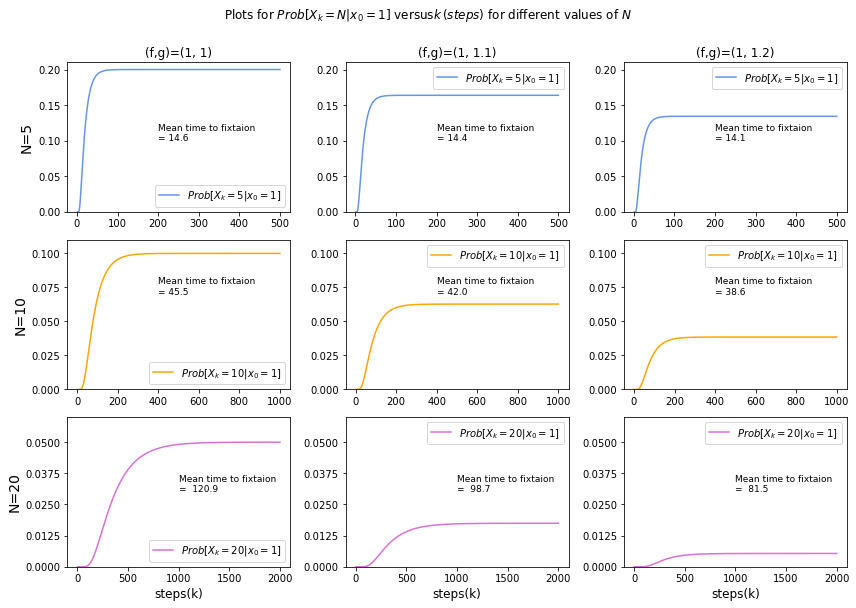

In [36]:
start = timeit.default_timer()

pop_vec = [5, 10, 20]
pows = [500, 1000, 2000]
fit_vec = [(1,1), (1,1.1), (1,1.2)]
x0 = 1

fixation_plots(pop_vec, pows, fit_vec, x0)

# timing        
end = timeit.default_timer()
print('run time = %1.2f sec.'%(end-start))

As we can see from the plots, probability of fixation is $1/N$ for $f=g=1$ and smaller than $1/N$ if $f<g$. The reason is since $\mu_a=\mu_A=0$, as $g$ increases, the probability of birth for allele $a$ decreases (and prob of death increases) and hence starting from $X_0=1$, it's now more likely for $a$ to reach state 0 or less likely to reach state $N$. This also shows why mean-time to fixation decreases as $g$ increases, because it goes to state 0 faster.   

The next question is to find the steady state distributions for this Moran model with 3 different sets of $\mu_a >0$ and $\mu_A>0$. By definition, stationary distribution, $\pi$, is the solution of 

$$\pi\,P=\pi.$$

For this task, we note that, if $\mu_a,\mu_A>0$, then the Moran process is transient and aperiodic and hence the stationary distribution can be obtained from $P^{k}$ as $k$ goes to $\infty$. In this case the rows of $P^{k}$ converge to $\pi$. 

In the simualtion, $N=20$ is fixed and I have used 3 different mutation probabilities: $\mu_a=\mu_A=$ 0.005, 0.05 and 0.5 and the powers for transition matrix (number of steps) are chosen 50000, 20000 and 5000 respectively to converge to the stationary distribution.  Note that for the smaller values of $\mu_a=\mu_A$, we need more steps to get a good approximation for stationary distribution, because it seems that in those cases, the process have fewer jumps in a fixed period of time. Threrefore we need to increase the number of steps in order to see enough transitions to reach the stationary. Although we have used big numbers to take the power of transition matrix, we still see a very short run time for the simulation and so the idea of using the powers of transition matrix to find the staionary distribution is still very efficient in this Moran process.

In [12]:
def stationary_distribution(N, mu_a, mu_A,
                            f, g, k):
    P = transition_matrix(N, mu_a, mu_A, f, g)
    steady_state_approx = matrix_power(P, k)[0,:]
    return steady_state_approx

In [39]:
def stationary_plots(N, mut_vec, pows, fit_vec):
    fig, ax = plt.subplots(len(mut_vec), len(fit_vec), figsize=(12,8)) 
    samples = 1000
    mutations = zip(mut_vec, pows)
    for i,((mu_a, mu_A), k) in enumerate(mutations):
        for j, (f,g) in enumerate(fit_vec):     
            P = transition_matrix(N, mu_a, mu_A, f, g)
            steady_state_approx = stationary_distribution(N, mu_a, mu_A,
                                                          f, g, k)
            state_frequency = steady_state_approx * samples
            mean_state = np.dot(state_frequency, np.arange(N+1))/samples
            ax[i,j].bar(np.arange(N+1), state_frequency)
            ax[i,j].axvline(x=mean_state, ymin=0, ymax=0.95, linestyle='dashed',\
                            color ='green', label='Mean')
            ax[0,j].set_title('(f,g)={}'.format((f,g)), fontsize=12)
            ax[-1,j].set_xlabel('states', fontsize=12)
            ax[i,0].set_ylabel('$\mu_a$=$\mu_A$={}'.format(mu_a), fontsize=12)  
            ax[i,j].legend()
            ax[i,j].set_ylim([0,max(state_frequency)+30])  
            plt.tight_layout()          
            plt.suptitle('Frequncy of states at stationary for N=20 in 1000'\
                         ' samples:\n Green dashed line is the average',y=1.05)  

run time = 1.41 sec.


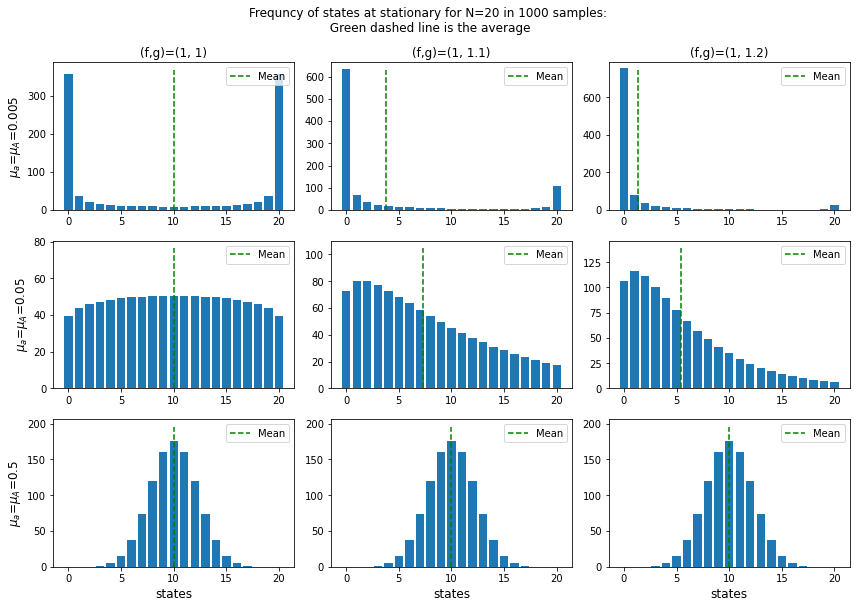

In [40]:
start = timeit.default_timer()

N = 20            
mut_vec = [(0.005,0.005), (0.05,0.05), (0.5,0.5)]
pows = [50000, 20000, 5000]
fit_vec = [(1,1), (1,1.1), (1,1.2)]

stationary_plots(N, mut_vec, pows, fit_vec)

# timing        
end = timeit.default_timer()
print('run time = %1.2f sec.'%(end-start))

As we can see from the plots, for case $f=g$ we have symmetric plots. Symmetry comes from the fact that if $f=g$ and $\mu_a=\mu_A$, then 

$$ P(j+1\,|\,j) = P(N-j-1\,|\,N-j)$$

Probability of birth for allele $a$ at state $j$ is the same as probability of birth for allele $A$ at state $j$.

Also for cases $\mu_a=\mu_A=0.005$ and $\mu_a=\mu_A=0.05$, it seems that as $g$ increases the probability of birth for allele $a$ decreases and probability of death increases and therefore the Moran process is more likely at states close to 0. For special case $\mu_a=\mu_A=0.5$ we can see from transition matrix that probability of birth or death doesn't depend on $f$ and $g$, because in this case $s_a$ and $s_A$ don't depend of $f$ and $g$ and that's why we don't see any difference in the last row of the plots. 

Note that in general if $f<g$, it doesn't neccessarily imply that at stationary the process will be at state 0 with higher probability than being at state $N$. For example for $f=1$, $g=20$ and $\mu_a=\mu_A =0.9$, we can see the the opposit happenes.


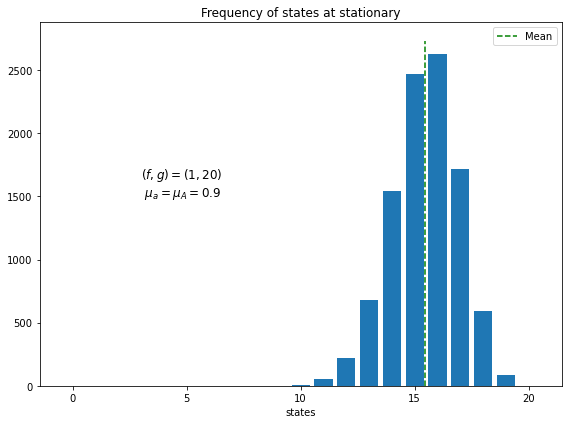

In [24]:
fig, ax = plt.subplots(1, figsize=(8,6)) 
N = 20            
mu_a, mu_A = 0.9, 0.9
k = 20000
f, g= 1, 20
samples = 10000

P = transition_matrix(N, mu_a, mu_A, f, g)
steady_state_approx = stationary_distribution(N, mu_a, mu_A, f, g, k)
state_frequency = steady_state_approx * samples
mean_state = np.dot(state_frequency, np.arange(N+1))/samples
ax.bar(np.arange(N+1), state_frequency)
ax.axvline(x=mean_state, ymin=0, ymax=0.95, linestyle='dashed',\
           color ='green', label='Mean')
ax.set_title('Frequency of states at stationary')
ax.set_xlabel('states')
ax.legend()
ax.text(3,1500,'$(f,g)={}$ \n $\mu_a=\mu_A={}$'.format((f,g),mu_a), fontsize=12)
ax.set_ylim([0,max(state_frequency)+250])    
plt.tight_layout()          